In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget

In [2]:
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical

# IO utils


In [3]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [4]:
palm_file = './data/2023-05-31_17-14-41.palm'
gestures = read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print(gestures.shape)
gestures.head()

(19568, 65)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,ACC0,ACC1,ACC2,GYR0,GYR1,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,12,8,5,6,2,4,5,7,14,8,0,13,2783,36,4,0,3193,1827,8,4,26,2763,2299,10,2,0,34,2562,1969,11,3199,2597,38,5,2,4,7,33,3184,1639,42,26,14,11,2,2,10,12,44,28,-45,53,95,-15,-29,-13,0,0,0,0,0,0,0,0,555777
1,13,8,4,5,3,0,5,4,9,10,5,11,2794,34,3,2,3201,1833,6,2,34,2771,2316,10,3,0,35,2572,1981,10,3216,2604,38,5,2,1,6,40,3196,1650,35,23,14,8,3,1,10,14,32,27,-46,53,94,-4,-45,-16,0,0,0,0,0,0,0,0,555810
2,12,5,9,5,0,0,6,5,10,9,6,11,2795,35,5,1,3210,1837,8,0,27,2766,2312,7,2,4,31,2563,1973,9,3199,2600,35,5,3,3,5,33,3184,1641,38,33,14,9,2,0,19,14,41,27,-45,50,103,-16,-26,-14,0,0,0,0,0,0,0,0,555843
3,10,7,6,4,1,0,4,6,7,8,5,10,2796,33,3,0,3221,1839,6,1,35,2773,2322,7,3,0,36,2574,1986,8,3216,2610,38,5,3,1,7,38,3199,1651,37,20,14,10,3,0,12,11,32,27,-47,51,101,-16,-12,-12,0,0,0,0,0,0,0,0,555876
4,12,6,6,7,3,2,6,7,9,12,6,11,2795,35,4,4,3228,1838,8,1,13,2775,2323,8,2,0,32,2576,1990,10,3207,2603,37,5,3,4,8,34,3191,1645,39,21,14,11,3,1,14,12,42,30,-52,52,111,-13,-2,-12,0,0,0,0,0,0,0,0,555909


In [5]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [6]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


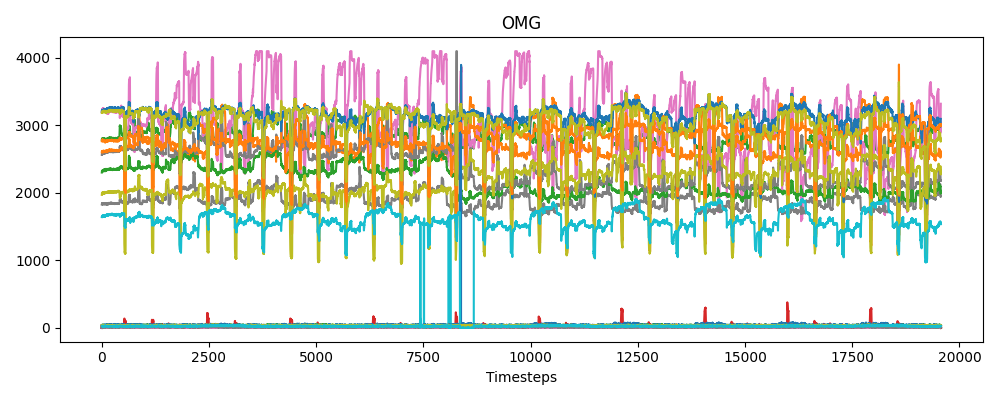

In [7]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

### Protocol

In [8]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol.head(10)

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [9]:
gestures_protocol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181 entries, 0 to 180
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Thumb           181 non-null    float64
 1   Index           181 non-null    float64
 2   Middle          181 non-null    float64
 3   Ring            181 non-null    float64
 4   Pinky           181 non-null    float64
 5   Thumb_stretch   181 non-null    float64
 6   Index_stretch   181 non-null    float64
 7   Middle_stretch  181 non-null    float64
 8   Ring_stretch    181 non-null    float64
 9   Pinky_stretch   181 non-null    float64
 10  Pronation       181 non-null    float64
dtypes: float64(11)
memory usage: 17.0 KB


In [10]:
gestures['SYNC'].value_counts()

SYNC
0      11266
57        58
67        58
97        47
135       47
       ...  
52        46
1         45
103       45
104       45
12        39
Name: count, Length: 181, dtype: int64

In [11]:
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [12]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [13]:
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int64

In [14]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

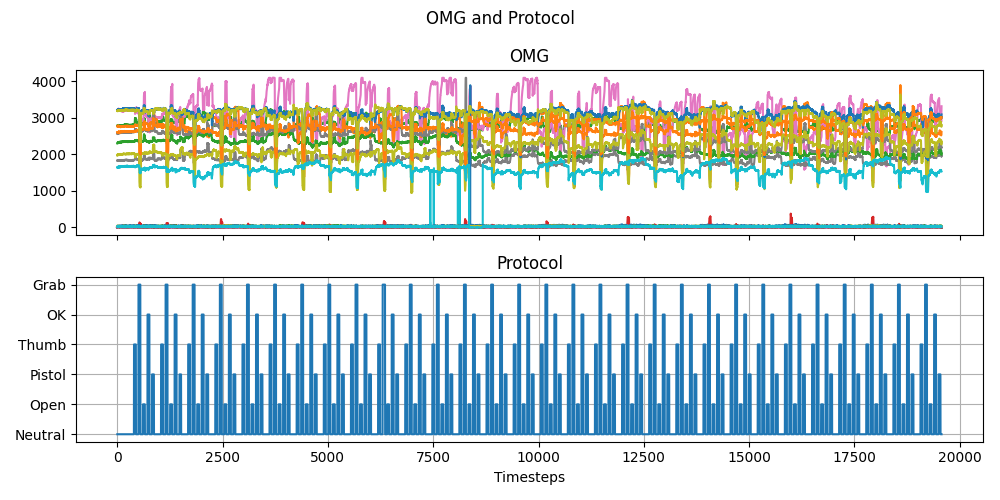

In [15]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

___
___
___

## Определение временной задержки целевой переменной.

In [16]:
def add_feature_derivative(df):
  """Функция для добавления признака производной

    Args:
        df (DataFrame): датасет

    Returns:
        df_log(DataFrame): датасет с добавленным признаком производной
  """
  col_list_base = list(df.columns) #исходный список признаков
  df_temp = df.copy()
  for i in col_list_base:
    col_add = f'der_{i}' #название для нового признака
    df_temp[col_add] = df_temp[i].diff() #создаем признак
    df_temp.fillna(0, inplace = True) #удаляем пустоты
  df_temp.drop(col_list_base, axis = 1 , inplace = True)
  return df_temp

def get_clean_lines(df, treshold = 1.5):
  """Функция для преобразования временного ряда.
  Преобразует все значения выше определенного порога в 1, ниже в 0

    Args:
        df (Series): датасет

    Returns:
        result(DataFrame): преобразованный датасет
  """
  result = np.zeros(df.shape) #создаем массив заполненный нулями размером с датасет
  means = np.mean(df) #выводим среднюю
  for i in range(df.shape[0]): #перебираем значения
    if abs(df[i]) > means*treshold:  #реализуем логику
      result[i] = 1
    else:
      result[i] = 0
  return pd.DataFrame(result)

def shift_definition(df, target):
  """Функция для нахождения временной задержки между командой и её исполнением

    Args:
        df (DataFrame): датасет с показаниями датчиков
        target (DataFrame): данные протокола выполнения команд
    Returns:
        best_shift (int): временной сдвиг
  """
  # рассчитываем производные значений временных датчиков
  gestures_der = add_feature_derivative(df)
  # суммируем модули значений производных
  gestures_der_sum = abs(gestures_der).sum(axis = 1)
  # обнуляем значения ниже порога
  gestures_der_sum_clean = get_clean_lines(gestures_der_sum, treshold = 1.5)

  # преобразуем целевую переменную в DataFrame
  target_df = pd.DataFrame(target)
  # рассчитываем производные значений таргета
  target_der = add_feature_derivative(target_df)
  # преобразуем таргет, если есть жест 1, если нет 0
  for i in range(len(target_der)):
      if (target_der.iloc[i] != 0).bool():
        target_der.iloc[i] = 1

  # объединяем преобразованный таргет и преобрразованную сумму производных в одну таблицу
  data = pd.concat([gestures_der_sum_clean.shift(1), target_der], axis=1).dropna()
  data.columns = ['y_t', 'first_derivative']
  # определяем, при каком сдвиге корреляция  максимальна
  corr_temp = []
  for i in range(1, 40):
    data['y_t'] = data['y_t'].shift(i)
    corr_coef = data.corr()
    corr_temp.append(corr_coef.iloc[1,0])
  l = pd.Series(corr_temp)
  best_shift = l[l == max(corr_temp)]
  return best_shift.index[0]

In [17]:
best_shift = shift_definition(gestures[OMG_CH + ACC_CH + GYR_CH + ENC_CH], y_cmd)
print(best_shift)

/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_1338/3135940893.py:60: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (target_der.iloc[i] != 0).bool():


23


In [18]:
# сдвигаем значения таргета
target_df = pd.DataFrame(y_cmd)
target_df = target_df.shift(best_shift).fillna(0)
y_cmd_shift = target_df.values
y_cmd_shift = np.ravel(y_cmd_shift.astype(int))
y_cmd_shift

array([0, 0, 0, ..., 0, 0, 0])

## Предобработка данных

## Добавление признака с экспоненциально взвешенными скользящими средними

In [19]:
def add_ewm_feature(df, span=10):
    """
    Функция для добавления столбцов с экспоненциально взвешенными скользящими средними (ewm)
    для каждого признака в ndarray формата numpy.

    Args:
        df (ndarray): Исходный массив данных в формате numpy
        span (int): Параметр span для расчета ewm (по умолчанию 10)

    Returns:
        ndarray: Массив данных с добавленными столбцами 'ewm' для каждого признака
    """
    df_temp = df.copy()
    col_count = df_temp.shape[1]
    new_cols = []
    for i in range(col_count):
        new_col = df_temp[:, i].cumsum() / (np.arange(df_temp.shape[0]) + 1)
        df_temp = np.column_stack((df_temp, new_col))
        new_cols.append(new_col)

    df_temp = np.delete(df_temp, range(col_count), axis=1)  # удаление исходных признаков

    return df_temp

In [20]:
g = gestures[OMG_CH].values
gestures_add_ewm = add_ewm_feature(g)
gestures_add_ewm.shape

(19568, 50)

## Добавление суммы изменений признака за последние несколько временных шагов.

In [21]:
def add_weight_sum(arr, size=5, win_type='triang'):
    """
    Функция для добавления признака скользящей суммы с весами значений для массива данных в формате numpy.

    Args:
        arr (ndarray): Исходный массив данных в формате numpy
        size (int): Размер окна для скользящей суммы (по умолчанию 5)
        win_type (str): Тип оконной функции для вычисления весов (по умолчанию 'triang')

    Returns:
        ndarray: Массив данных с добавленным признаком скользящей суммы с весами значений
    """
    arr_temp = arr.copy()
    col_count = arr_temp.shape[1]
    new_cols = [] #сохраним преобразованные столбцы в отдельный список
    for i in range(col_count):
        new_col = np.convolve(arr_temp[:, i], np.ones(size)/size, mode='same')
        arr_temp = np.column_stack((arr_temp, new_col))
        new_cols.append(new_col)
    arr_temp = np.delete(arr_temp, range(col_count), axis=1)  # удаление преобразованных признаков
    return arr_temp

In [22]:
gestures_weight_sum = add_weight_sum(g, size = 5, win_type = 'triang')
gestures_weight_sum.shape

(19568, 50)

## Добавление лагов

In [23]:
def add_lag(df, step=2, lag_n=3):
    """
    Функция для добавления временных лагов в выборку с шагом
        Args:
        df (ndarray): выборка в формате numpy
        lag_n(int): количество временных лагов
        step(int): шаг сдвига по признакам

    Returns:
        df_temp(ndarray): датасет с добавленными временными лагами, пропуски заполнены 0
    """

    df_temp = df.copy()  # создаем новый датасет для добавления новых признаков
    n_samples, n_features = df_temp.shape
    col_indices = list(range(0, n_features, step))  # список индексов признаков с шагом

    for col_idx in col_indices:
        col = df_temp[:, col_idx]  # выбираем признак с шагом

        for v in range(1, lag_n):
            lag_col = np.roll(col, v) if v <= col_idx else np.zeros(n_samples)  # сдвигаем признак
            df_temp = np.column_stack((df_temp, lag_col))  # добавляем новый признак

    df_temp = np.delete(df_temp, col_indices, axis=1)  # удаляем исходные признаки

    return df_temp

In [24]:
gestures_add_lag = add_lag(g, 2, 3) #выполняем функцию сдвига признаков с лагом
# gestures_add_lag.shape

In [25]:
df_prepros = np.concatenate([g, gestures_add_ewm, gestures_weight_sum, gestures_add_lag], axis=1)
# df_prepros = np.concatenate([g, gestures_add_ewm, gestures_weight_sum], axis=1)
df_prepros.shape

(19568, 225)

# Train-test split

In [26]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [27]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15679

In [28]:
num_classes = len(set(y_cmd_shift))
num_samples = len(y_cmd_shift)
one_hot_target = np.zeros((num_samples, num_classes))

# Subtract 1 from target labels
adjusted_target = y_cmd_shift - 1

one_hot_target[np.arange(num_samples), adjusted_target] = 1

In [29]:
# def add_lag(df, lag=40):
#     columns = [df.shift(i) for i in range(lag)]
#     df = pd.concat(columns, axis=1)
#     df = df.fillna(0)
    
#     return df.values


In [30]:
# df = pd.DataFrame(df_prepros)

In [31]:
from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(add_lag(df, lag=20))
# df_scaled = scaler.fit_transform(add_lag(df, lag=20))

In [32]:
# df_3d = df_scaled.reshape(df_scaled.shape[0], 20, 225)

In [33]:
def add_lag_3d(df, lag=40):
    columns = [df.shift(i) for i in range(lag)]
    df_concat = pd.concat(columns, axis=1)
    df_concat = df_concat.fillna(0)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_concat)
    return scaled_data.reshape(scaled_data.shape[0], lag, df.shape[1])


df = pd.DataFrame(df_prepros)
df_3d = add_lag_3d(df, lag=20)

In [34]:
X_train = df_3d[:last_train_idx]
y_train_encode = one_hot_target[:last_train_idx]

X_test = df_3d[last_train_idx:]
y_test_encode = one_hot_target[last_train_idx:]

print(X_train.shape, y_train_encode.shape)
print(X_test.shape, y_test_encode.shape)

(15679, 20, 225) (15679, 6)
(3889, 20, 225) (3889, 6)


# Modeling

In [35]:
# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression()

# model.fit(
#     X=X_train,
#     y=y_train
# )

In [36]:
import seaborn as sns

# plt.figure(figsize=(10, 3)) # 
# sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
# plt.tight_layout()

___
___
___

In [37]:
def plot_accur(history, epochs=20):
    acc = history.history['f1_score']
    val_acc = history.history['val_f1_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Mean F-score')
    plt.plot(epochs_range, val_acc, label='Validation Mean F-score')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Mean F-score')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [38]:
def f1_score(y_true, y_pred):
    # Function to calculate F-score
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [39]:
import tensorflow as tf

In [40]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [41]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import Input
from keras.optimizers.legacy import Adam
from keras.layers import Dropout
from keras.regularizers import l1,l2
from keras.layers import GRU
from keras import backend as K 
from keras import callbacks

n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_classes = y_train_encode.shape[1]

GRU

In [42]:
model_gru = Sequential()
model_gru.add(GRU(units=32, kernel_regularizer=l2(0.1), return_sequences=True, input_shape=(n_timesteps, n_features), dropout=0.5))
model_gru.add(GRU(units=16, input_shape=(n_timesteps, n_features), dropout=0.5))
model_gru.add((Dense(n_classes, activation='softmax')))

optimizer = Adam()

model_gru.compile(loss='categorical_crossentropy', 
                   optimizer=optimizer, 
                   metrics=[f1_score])

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min", patience=20,
    restore_best_weights=True
)

history_gru = model_gru.fit(X_train, 
                    y_train_encode, 
                    epochs=100, 
                    batch_size=32,
                    validation_split=0.25,
                    callbacks=earlystopping
                    )

K.clear_session()

2024-03-01 21:30:23.281880: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-01 21:30:23.281917: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-01 21:30:23.281932: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-01 21:30:23.282224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-01 21:30:23.282672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-03-01 21:30:25.316075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


368/368 [==============================] - 17s 42ms/step - loss: 2.4893 - f1_score: 0.6977 - val_loss: 0.7867 - val_f1_score: 0.7489
Epoch 2/100
368/368 [==============================] - 15s 40ms/step - loss: 0.4897 - f1_score: 0.8758 - val_loss: 0.7730 - val_f1_score: 0.7762
Epoch 3/100
368/368 [==============================] - 15s 40ms/step - loss: 0.4124 - f1_score: 0.9122 - val_loss: 0.5977 - val_f1_score: 0.8381
Epoch 4/100
368/368 [==============================] - 15s 40ms/step - loss: 0.3604 - f1_score: 0.9249 - val_loss: 0.5258 - val_f1_score: 0.8684
Epoch 5/100
368/368 [==============================] - 14s 39ms/step - loss: 0.3182 - f1_score: 0.9362 - val_loss: 0.6519 - val_f1_score: 0.8363
Epoch 6/100
368/368 [==============================] - 14s 39ms/step - loss: 0.3136 - f1_score: 0.9366 - val_loss: 0.4017 - val_f1_score: 0.8982
Epoch 7/100
368/368 [==============================] - 14s 39ms/step - loss: 0.2957 - f1_score: 0.9404 - val_loss: 0.3259 - val_f1_score: 0.92

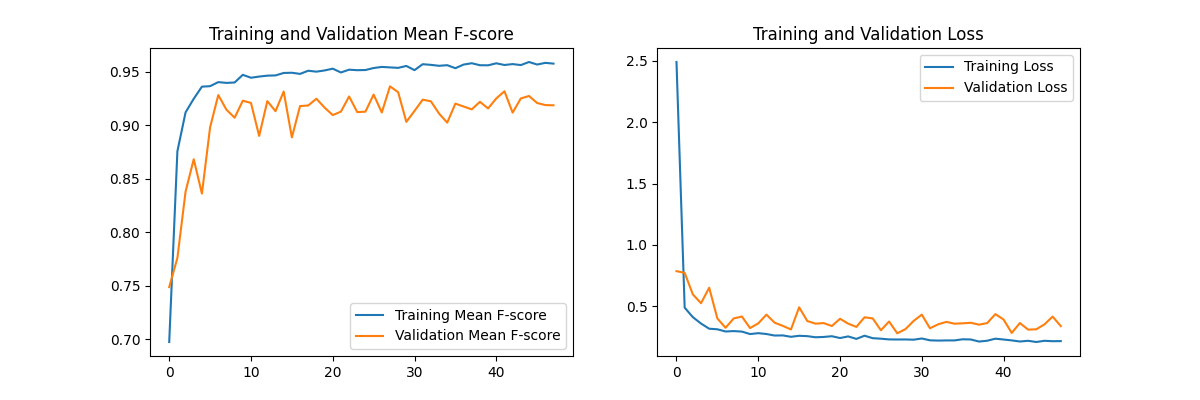

In [49]:
plot_accur(history_gru, epochs=48)

### Подбор гиперпараметров

In [ ]:
# import optuna
# from sklearn.metrics import f1_score
# from tensorflow.keras.metrics import Metric

# # Define a custom F1-score metric using TensorFlow operations
# class F1Score(Metric):
#     def __init__(self, name='f1_score', **kwargs):
#         super(F1Score, self).__init__(name=name, **kwargs)
#         self.true_positives = self.add_weight(name='tp', initializer='zeros')
#         self.false_positives = self.add_weight(name='fp', initializer='zeros')
#         self.false_negatives = self.add_weight(name='fn', initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(tf.math.round(y_pred), tf.float32)

#         tp = tf.reduce_sum(y_true * y_pred)
#         fp = tf.reduce_sum(y_pred) - tp
#         fn = tf.reduce_sum(y_true) - tp

#         self.true_positives.assign_add(tp)
#         self.false_positives.assign_add(fp)
#         self.false_negatives.assign_add(fn)

#     def result(self):
#         precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
#         recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
#         f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
#         return f1

# # Define the objective function
# def objective(trial):
#     # Define hyperparameters to search
#     n_units = trial.suggest_int('n_units', 16, 64)
#     dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
#     learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)
#     batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

#     # Create GRU model
#     model = tf.keras.Sequential([
#         GRU(units=n_units, dropout=dropout_rate, return_sequences=True, input_shape=(n_timesteps, n_features)),
#         GRU(units=n_units, dropout=dropout_rate),
#         Dense(n_classes, activation='softmax')
#     ])

#     # Compile the model with custom F1-score metric
#     optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[F1Score()])

#     # Train the model
#     history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.25, callbacks=earlystopping)

#     # Return F1-score from validation set
#     return history.history['val_f1_score'][-1]

# # Create an Optuna study
# study = optuna.create_study(direction='maximize')

# # Optimize the study
# study.optimize(objective, n_trials=100, callbacks=[optuna.callbacks.EarlyStoppingCallback(patience=5)])

# # Get the best hyperparameters
# best_params = study.best_params

___
___
___

## Prediction

In [50]:
y_pred_train = model_gru.predict(X_train)
y_pred_test = model_gru.predict(X_test)

122/122 [==============================] - 1s 8ms/step


In [51]:
def y_to_2d(y):
    y = np.round(y)
    indices_of_1 = np.argmax(y, axis=1)
    indices_of_1 = indices_of_1 + 1
    indices_of_1[indices_of_1 == 6] = 0
    return indices_of_1

In [52]:
y_pred_train = y_to_2d(y_pred_train)
y_pred_test = y_to_2d(y_pred_test)

In [53]:
y_train = y_cmd_shift[:last_train_idx]
y_test = y_cmd_shift[last_train_idx:]

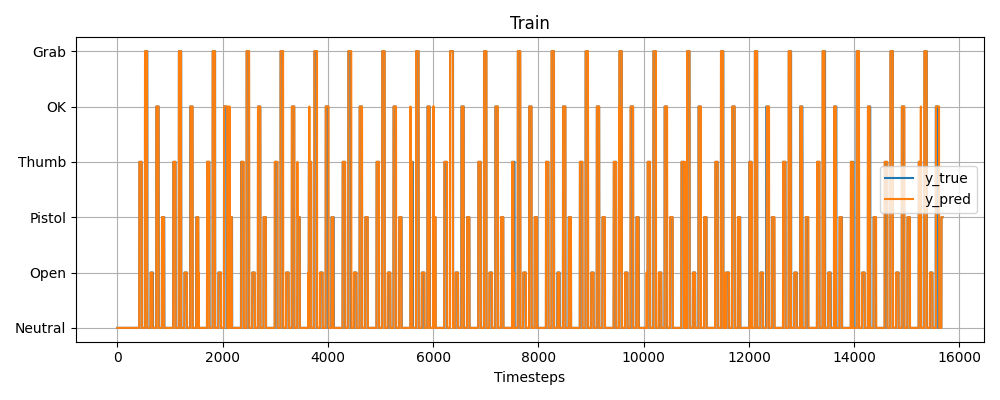

In [54]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

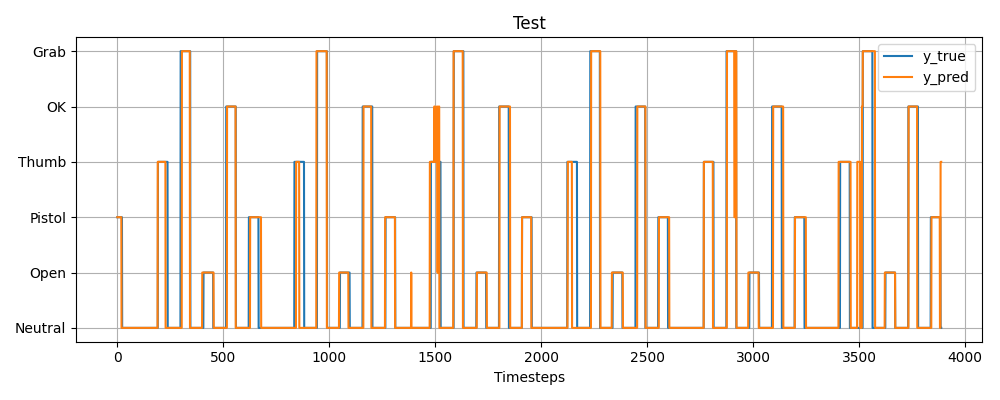

In [55]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_train, target_names=GESTURES))
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.97      0.96      0.97     10174
        Open       0.89      0.97      0.93      1104
      Pistol       0.96      0.92      0.94      1075
       Thumb       0.93      0.89      0.91      1104
          OK       0.91      0.93      0.92      1104
        Grab       0.95      0.95      0.95      1118

    accuracy                           0.95     15679
   macro avg       0.93      0.94      0.94     15679
weighted avg       0.95      0.95      0.95     15679

              precision    recall  f1-score   support

     Neutral       0.94      0.95      0.94      2485
        Open       0.88      0.96      0.92       276
      Pistol       0.89      0.93      0.91       299
       Thumb       0.84      0.67      0.75       276
          OK       0.90      0.88      0.89       276
        Grab       0.93      0.91      0.92       277

    accuracy                           0.92      3889
   macro avg       0.90

# Real-time inference

In [52]:
import time
import serial
from IPython.display import clear_output

In [53]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [67]:
def preprocessing(x, n_lags):
    if len(x) < n_lags:
        # print(0)
        return np.zeros(225)
    else:
        # x - sample vector
        data_n = np.array(x)
        # Добавление признака с экспоненциально взвешенными скользящими средними
        data_add_ewm = add_ewm_feature(data_n)
        # Добавление суммы изменений признака за последние несколько временных шагов.
        data_weight_sum = add_weight_sum(data_n, size = 5, win_type = 'triang')
        # Добавление лагов
        data_add_lag = add_lag(data_n, step = 2, lag_n = 3) #выполняем функцию сдвига признаков с лагом
        # объединение преобразований
        df = np.concatenate([data_n, data_add_ewm, data_weight_sum, data_add_lag], axis=1)
        #Преобразование 
        df = pd.DataFrame(df)
        x = add_lag_3d(df, lag=n_lags)
        
        return x

def inference(x):
    y = model_gru.predict(x)
    return y

def postprocessing(x, prev):
    x = y_to_2d(x)
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [62]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [64]:
df_sim

,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
15679,0,6,6,4,1,0,5,4,11,6,...,-2,0,0,0,0,0,0,0,0,1073184
15680,11,14,6,0,2,1,6,4,11,7,...,-3,0,0,0,0,0,0,0,0,1073217
15681,11,6,5,6,2,2,5,5,9,8,...,-4,0,0,0,0,0,0,0,0,1073250
15682,11,6,6,4,1,2,4,4,8,9,...,-5,0,0,0,0,0,0,0,0,1073283
15683,10,7,5,4,2,0,4,6,8,9,...,-4,0,0,0,0,0,0,0,0,1073316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19563,3,6,7,4,2,0,6,3,13,8,...,1,0,0,0,0,0,0,0,0,1201356
19564,26,6,5,3,2,1,4,4,9,7,...,-2,0,0,0,0,0,0,0,0,1201389
19565,14,7,6,4,2,0,6,5,13,8,...,0,0,0,0,0,0,0,0,0,1201422
19566,30,6,6,4,2,0,5,5,10,6,...,-1,0,0,0,0,0,0,0,0,1201455


In [65]:
[omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(df_sim.values[0], [50, 56, 62])
omg_sample

array([   0,    6,    6,    4,    1,    0,    5,    4,   11,    6,    0,
          3, 2951,   19,    4,    0, 2864, 2097,    2,    1,   30, 2581,
       2194,    7,    2,    0,   29, 2298, 2293,    8, 3015, 2831,   41,
          6,    2,    4,   10,   32, 2989, 1566,   37,   21,   13,    8,
          2,    1,   11,   10,   35,   24])

In [68]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample, n_lags=20)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

IndexError: tuple index out of range

In [29]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3889, 50)
enc_sample.shape = (3889, 6)
sample_preprocessed.shape = (3889, 50)
y_predicted.shape = (3889, 1)
y_postprocessed.shape = (3889, 1)
y_commands.shape = (3889, 1)


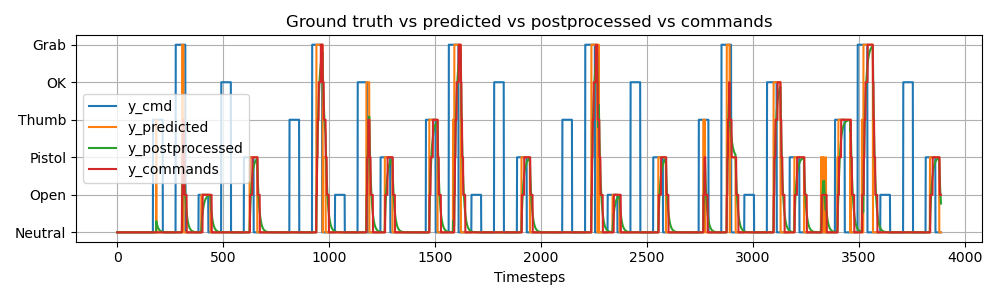

In [30]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [31]:
print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.67      0.78      0.72      2508
        Open       0.11      0.16      0.13       276
      Pistol       0.22      0.23      0.23       276
       Thumb       0.20      0.11      0.14       276
          OK       0.00      0.00      0.00       276
        Grab       0.12      0.02      0.04       277

    accuracy                           0.54      3889
   macro avg       0.22      0.22      0.21      3889
weighted avg       0.48      0.54      0.50      3889



### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 